In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare WA_Fn-UseC_-Telco-Customer-Churn dataset
print("Loading WA_Fn-UseC_-Telco-Customer-Churn dataset...")
df = pd.read_csv('data_files/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert the totalCharges column to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
print(df.info())

print("\nFirst few rows:")
df.head()

# Convert categorical variables to numeric representation
print("Converting categorical variables to numeric representation...")
print("=" * 55)

# Remove Phone feature as it's not useful for prediction (unique identifier)
if 'Phone' in df.columns:
    df = df.drop('Phone', axis=1)
    print("Removed 'Phone' column as it's a unique identifier not useful for prediction")
    print(f"Dataset shape after removing Phone: {df.shape}")
    print()


# Get categorical columns (excluding customerID which is just an identifier)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

print(f"Categorical columns to convert: {categorical_cols}")
print()

# Create a copy of the dataframe for encoding and remove null data
df = df.dropna()
print(f"Removed null values. Dataset shape after removing nulls: {df.shape}")
df_encoded = df.copy() 

# Method 1: Label Encoding for binary categorical variables
from sklearn.preprocessing import LabelEncoder

binary_categorical = []
multi_categorical = []

# Identify binary vs multi-category variables
for col in categorical_cols:
    unique_values = df[col].nunique()
    if unique_values == 2:
        binary_categorical.append(col)
    else:
        multi_categorical.append(col)

print("Binary categorical variables (using Label Encoding):")
print(binary_categorical)
print()

# Apply Label Encoding to binary categorical variables
label_encoders = {}
for col in binary_categorical:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print()
print("Multi-categorical variables (using One-Hot Encoding):")
print(multi_categorical)
print()

# Method 2: One-Hot Encoding for multi-categorical variables
if multi_categorical:
    df_encoded = pd.get_dummies(df_encoded, columns=multi_categorical, prefix=multi_categorical, drop_first=True)

# Display the shape change
print(f"Original dataset shape: {df.shape}")
print(f"Encoded dataset shape: {df_encoded.shape}")
print()

# Show first few rows of encoded data
print("First 5 rows of encoded dataset:")
df_encoded.info()

# Scale numerical features using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns (excluding the target variable if it exists)
numerical_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable if it exists in the dataset
target_candidates = ['churn', 'Churn', 'target', 'Target']
for target in target_candidates:
    if target in numerical_cols:
        numerical_cols.remove(target)


# Apply Min-Max scaling to range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = df_encoded.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print()
print("First 5 rows of scaled dataset:")
df_scaled.head()

# Prepare data for Random Forest hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare features and target
X = df_scaled.drop('Churn', axis=1) if 'Churn' in df_scaled.columns else df_scaled.drop('churn', axis=1)
y = df_scaled['Churn'] if 'Churn' in df_scaled.columns else df_scaled['churn']

# Identify the target column
target_col = None
for col in ['churn', 'Churn', 'target', 'Target']:
    if col in df_scaled.columns:
        target_col = col
        break

if target_col is None:
    print("Warning: No target column found. Please specify the target column manually.")
    # Assuming the last column is the target for demonstration
    target_col = df_scaled.columns[-1]

print(f"Using '{target_col}' as target variable")

# Remove customerID column (identifier, not useful for prediction)
if 'customerID' in df_scaled.columns:
    df_scaled = df_scaled.drop('customerID', axis=1)
    print("Removed customerID column (identifier)")

# Separate features and target
X = df_scaled.drop(columns=[target_col])
y = df_scaled[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print()

# Check for any remaining object columns
object_columns = X.select_dtypes(include=['object']).columns
if len(object_columns) > 0:
    print(f"Warning: Found object columns: {list(object_columns)}")
    print("Removing object columns...")
    X = X.drop(object_columns, axis=1)
    print(f"Features shape after removing objects: {X.shape}")

Loading WA_Fn-UseC_-Telco-Customer-Churn dataset...
Dataset shape: (7043, 21)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 

KNN (k=8) Results:
Training Accuracy: 0.8222
Test Accuracy: 0.7683

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.8165    0.8829    0.8484      1033
           1     0.5828    0.4519    0.5090       374

    accuracy                         0.7683      1407
   macro avg     0.6996    0.6674    0.6787      1407
weighted avg     0.7543    0.7683    0.7582      1407

Confusion Matrix (Test Set):
[[912 121]
 [205 169]]


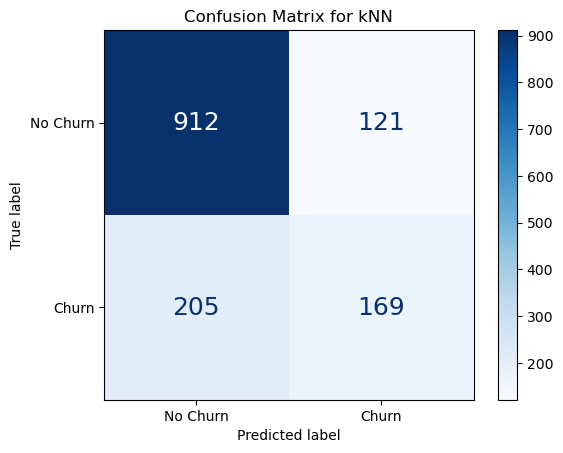

AUC-ROC Score: 0.7791


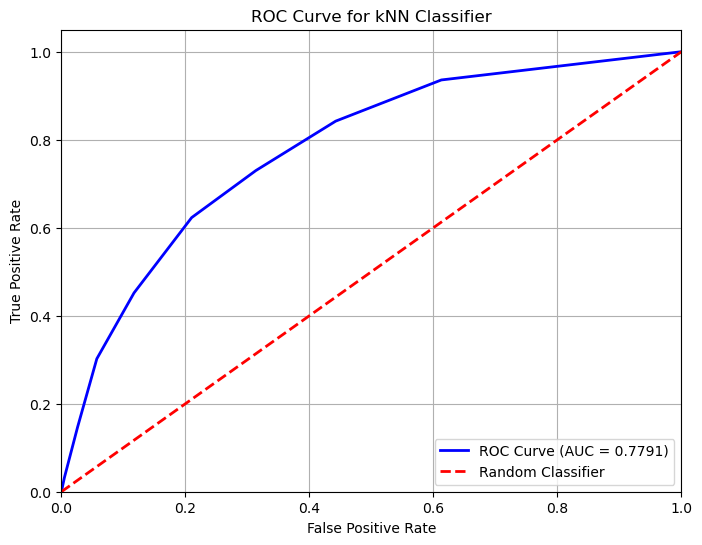

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Import KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Create KNN model with k=8
knn = KNeighborsClassifier(n_neighbors=8)

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"KNN (k=8) Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print()

# Display classification report for test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred,digits=4))

# Display confusion matrix
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap='Blues')

# Make numbers larger
for text in disp.ax_.texts:
    text.set_fontsize(18)  # Set your preferred font size
plt.grid(False)  
plt.title("Confusion Matrix for kNN")
plt.show()


# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get prediction probabilities for the positive class (churn)
y_test_proba = knn.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for kNN Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


